In [1]:
#Import packages etc
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#from paramsgen import create_param_grid



In [2]:
def read_csv_files(directory):
    csv_files = []
    # print(f"Checking files in directory: {directory}")
    for filename in os.listdir(directory):
        if filename.startswith("sub") and filename.endswith(".csv"):
            print(f"Reading CSV file: {filename}")
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            csv_files.append(df)
        else:
            print(f"Skipping file: {filename}")
    return csv_files

def map_prolific_ids(dataframe):
    unique_ids = dataframe['prolific_id'].unique()
    id_mapping = {id: (i % 100) + 1 for i, id in enumerate(unique_ids)}
    dataframe['prolific_id'] = dataframe['prolific_id'].map(id_mapping)
    return dataframe, id_mapping


In [3]:
# Get data
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, 'data')

# Load the task data only once
task_data_path = os.path.join(data_directory, 'task_data_nobehav.csv')
if os.path.exists(task_data_path):
    task_data = pd.read_csv(task_data_path)
    # print(task_data.head())

# Call the function and get the list of dataframes
dataframes = read_csv_files(data_directory)

# Ensure task_data is not included in the dataframes list
dataframes = [df for df in dataframes if not df.equals(task_data)]

# Display the first few rows of each DataFrame and the 'effLevel' column
# for i, df in enumerate(dataframes):
    # print(f"First few rows of DataFrame {i+1}:")
    # print(df.head())

# Concatenate all DataFrames into one
big_dataframe = pd.concat(dataframes, ignore_index=True)

# Get current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
id_mapping_df_var_name = f"id_mapping_df_{current_time}"

# Map prolific_id to numbers 1-100
big_dataframe, id_mapping_df = map_prolific_ids(big_dataframe)
# Delete all rows from big_dataframe where effLevel is NaN
big_dataframe = big_dataframe.dropna(subset=['effLevel'])
big_dataframe.to_csv(os.path.join(data_directory, 'big_dataframe.csv'), index=False)
big_dataframe = big_dataframe.dropna(subset=['trials.thisN'])
big_dataframe = big_dataframe.dropna(axis=1, how='all')
print(big_dataframe['Points'], big_dataframe['effLevel'],
      big_dataframe['percentage of bar reached'])
big_dataframe.to_csv(os.path.join(data_directory, 'big_dataframe.csv'), index=False)

Reading CSV file: sub-66a8029007c122fe8086afcb_rewardeffortlearning_2024-09-06_11h17.22.698.csv
Skipping file: sub-6547bf8012d4702680d55663_rewardeffortlearning_2024-09-06_10h30.03.678.log.gz
Reading CSV file: sub-55bd8669fdf99b5bfc7d4cfc_rewardeffortlearning_2024-09-06_11h25.07.641.csv
Reading CSV file: sub-63474e67a5fd298c6103c409_rewardeffortlearning_2024-09-06_10h50.53.039.csv
Reading CSV file: sub-5cba9a8a214b1a0016ccf708_rewardeffortlearning_2024-09-06_08h21.17.302.csv
Skipping file: sub-601b28841ca7bb2f8edaa293_rewardeffortlearning_2024-09-06_11h16.31.372.log.gz
Skipping file: PARTICIPANT_RewardEffortLearning_pilot2_2024-09-06_11h56.00.479.log.gz
Skipping file: .DS_Store
Skipping file: PARTICIPANT_RewardEffortLearning_pilot2_2024-09-06_11h53.27.161.csv
Skipping file: sub-66706a23c37c6099480f039d_rewardeffortlearning_2024-09-06_11h17.32.305.log.gz
Skipping file: sub-600319e3a3b1a337cab57a3e_rewardeffortlearning_2024-09-06_11h19.10.675.log.gz
Skipping file: sub-6333926e48c34a5d393

In [4]:
# Adapt the task_data to match the simulation scripts
task_data.rename(columns={'Points': 'reward', 'effLevel': 'threshold'}, inplace=True)
task_data = task_data[['reward', 'threshold']]

big_dataframe = big_dataframe.dropna(subset=['trials.thisTrialN'])
big_dataframe.rename(columns={'Points': 'reward', 'effLevel': 'threshold', 'prolific_id':'id',
                          'percentage of bar reached':'chosen_effort','trials.thisTrialN':'trial'}, inplace=True)

In [5]:
def normalize_column(dataframe, column_name):
    """
    Rescale the indicated column to [0..100].
    """
    min_val = dataframe[column_name].min()
    max_val = dataframe[column_name].max()
    scaled = (dataframe[column_name] - min_val) / (max_val - min_val) #100.0 *
    return scaled


In [6]:
# ================================================================
#  MODEL CLASSES (internal domain)
# ================================================================
class RewardLearner:
    """Rescorla-Wagner for reward in scaled domain."""
    def __init__(self, alpha_r=0.1, init_reward=40.0):
        # e.g. if real init guess=4, scaled=4*10=40
        self.alpha_r = alpha_r
        self.R_hat   = init_reward

    def update(self, received_reward_scaled):
        delta_r = received_reward_scaled - self.R_hat
        self.R_hat += self.alpha_r * delta_r
        return self.R_hat


class EffortLearner:
    """Learns threshold in [0..10] if EFFORT_SCALE=0.1."""
    def __init__(self, alpha_e=0.1, init_effort=5.0):
        # e.g. if real init guess=50, scaled=5
        self.alpha_e = alpha_e
        self.E_hat   = init_effort

    def update(self, threshold_scaled):
        delta_e = threshold_scaled - self.E_hat
        self.E_hat += self.alpha_e * delta_e
        self.E_hat = np.clip(self.E_hat, 0, MAX_EFFORT_SCALED)
        return self.E_hat


class EffortDiscounter:
    """
    Enumerates e in [0..MAX_EFFORT_SCALED].
    cost_on_success => if True, cost only subtracted upon success.
    success_func => 'normal' or 'logistic' for p_success.
    """
    def __init__(self,
                 kappa=2.0,
                 sigma=2.0,
                 beta=5.0,
                 success_func='normal',
                 cost_on_success=False,
                 policy='argmax'):
        self.kappa           = kappa
        self.sigma           = sigma
        self.beta            = beta
        self.success_func    = success_func
        self.cost_on_success = cost_on_success
        self.policy          = policy

    def p_success(self, e, E_hat):
        if self.success_func=='normal':
            return norm.cdf( (e - E_hat)/self.sigma )
        elif self.success_func=='logistic':
            return 1.0 / (1.0 + np.exp(-self.sigma*(e - E_hat)))
        else:
            raise ValueError(f"Unknown success_func {self.success_func}")

    def choose_effort(self, R_hat, E_hat):
        e_values = np.arange(MAX_EFFORT_SCALED+1)  # 0..10
        EU_values= []

        for e in e_values:
            p_succ = self.p_success(e, E_hat)

            if self.cost_on_success:
                # cost subtracted only on success
                EU = p_succ*(R_hat - self.kappa*e)
            else:
                # cost always paid
                EU = p_succ*R_hat - self.kappa*e

            EU_values.append(EU)

        EU_values = np.array(EU_values)
        if self.policy=='argmax':
            chosen_e = e_values[np.argmax(EU_values)]
        else:
            # softmax
            maxEU = np.max(EU_values)
            expEU = np.exp( self.beta*(EU_values - maxEU) )
            probs = expEU / np.sum(expEU)
            chosen_e = np.random.choice(e_values, p=probs)

        return chosen_e


In [7]:
# ================================================================
#  SIMULATION WITH SCALING + IGNORE ZERO-REWARD
# ================================================================
def simulate_experiment(num_trials,
                        data,
                        ignore_zero_reward=False,  # [IMPORTANT] skip zero-rwd trials?
                        reward_learner_params=None,
                        effort_learner_params=None,
                        discounter_params=None):

    # defaults:
    if reward_learner_params is None:
        reward_learner_params = {'alpha_r':0.3, 'init_reward':40.0}
    if effort_learner_params is None:
        effort_learner_params = {'alpha_e':0.3, 'init_effort':5.0}
    if discounter_params is None:
        discounter_params = {
            'kappa':2.0,
            'sigma':2.0,
            'beta':5.0,
            'success_func':'normal',
            'cost_on_success':False,
            'policy':'argmax'
        }

    # create model objects
    RL = RewardLearner(**reward_learner_params)
    EL = EffortLearner(**effort_learner_params)
    discounter = EffortDiscounter(**discounter_params)

    results = {
        'trial':[],
        'threshold_real':[],
        'reward_real':[],
        'chosen_effort_real':[],
        'outcome':[],
        'R_hat_real':[],
        'E_hat_real':[]
    }

    # clamp trials
    actual_num = min(num_trials, len(data))

    for t in range(actual_num):
        threshold_real = data.iloc[t]['threshold']
        reward_real    = data.iloc[t]['reward']

        # [IMPORTANT] skip zero reward if desired
        if ignore_zero_reward and reward_real==0:
            print(f"Skipping trial {t+1} (reward=0).")
            continue

        # scale them for internal domain
        threshold_scaled = threshold_real * EFFORT_SCALE
        reward_scaled    = reward_real    * REWARD_SCALE

        # current estimates in scaled domain
        R_hat_s = RL.R_hat
        E_hat_s = EL.E_hat

        # pick effort
        chosen_e_s = discounter.choose_effort(R_hat_s, E_hat_s)

        # success probability
        p_succ = discounter.p_success(chosen_e_s, E_hat_s)
        outcome = np.random.binomial(1, p_succ)
        rec_rwd_scaled = reward_scaled if outcome==1 else 0.0

        # update learners
        RL.update(rec_rwd_scaled)
        EL.update(threshold_scaled)

        # convert chosen_e_s back to real scale:
        chosen_e_real = chosen_e_s / EFFORT_SCALE
        # convert R_hat_s, E_hat_s if you want to store them:
        R_hat_real = RL.R_hat / REWARD_SCALE
        E_hat_real = EL.E_hat / EFFORT_SCALE

        # store in results
        results['trial'].append(t+1)
        results['threshold_real'].append(threshold_real)
        results['reward_real'].append(reward_real)
        results['chosen_effort_real'].append(chosen_e_real)
        results['outcome'].append(outcome)
        results['R_hat_real'].append(R_hat_real)
        results['E_hat_real'].append(E_hat_real)

    return pd.DataFrame(results)



Skipping trial 3 (reward=0).
Skipping trial 4 (reward=0).
Skipping trial 6 (reward=0).
Skipping trial 7 (reward=0).
Skipping trial 9 (reward=0).
Skipping trial 10 (reward=0).
Skipping trial 12 (reward=0).
Skipping trial 13 (reward=0).
Skipping trial 16 (reward=0).
Skipping trial 18 (reward=0).
Skipping trial 21 (reward=0).
Skipping trial 22 (reward=0).
Skipping trial 24 (reward=0).
Skipping trial 26 (reward=0).
Skipping trial 28 (reward=0).
Skipping trial 29 (reward=0).
Skipping trial 31 (reward=0).
Skipping trial 33 (reward=0).
Skipping trial 34 (reward=0).
Skipping trial 40 (reward=0).
Skipping trial 41 (reward=0).
Skipping trial 43 (reward=0).
Skipping trial 47 (reward=0).
Skipping trial 49 (reward=0).
Skipping trial 50 (reward=0).
Skipping trial 53 (reward=0).
Skipping trial 54 (reward=0).
Skipping trial 55 (reward=0).
Skipping trial 57 (reward=0).
Skipping trial 60 (reward=0).
   trial  threshold_real  reward_real  chosen_effort_real  outcome  \
0      1              48           

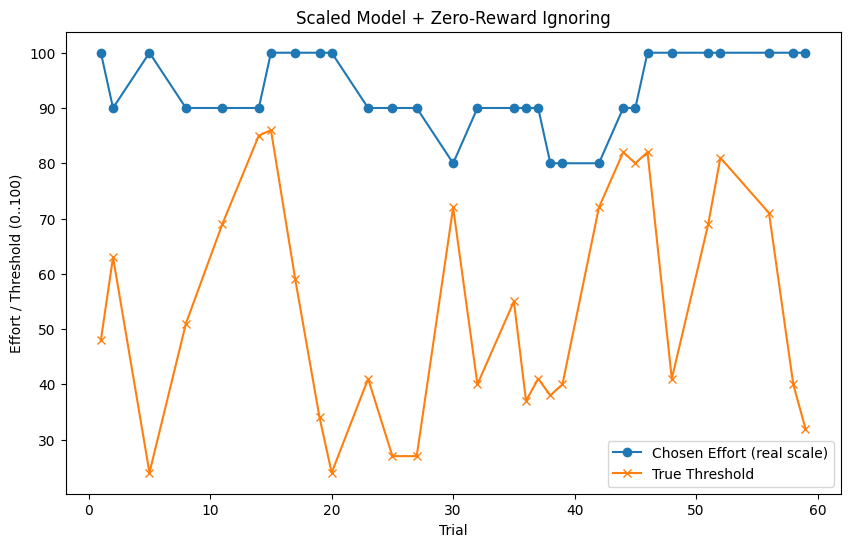

In [8]:
# Constants for internal scaling if you need them:
EFFORT_SCALE  = 0.1
REWARD_SCALE  = 10.0
MAX_EFFORT_SCALED = 10


def main():
    # Example mock data, with some zero rewards
    np.random.seed(123)
    mock_data = pd.DataFrame({
        'threshold': np.random.randint(0,101,size=60),
        'reward': np.random.randint(0,8,size=60)  # includes zeros
    })

    # define discounter_params in main
    discounter_params = {
        'kappa':0.6,
        'sigma':2.0,
        'beta':5.0,
        'success_func':'normal',
        'cost_on_success':False,
        'policy':'argmax'
    }

    sim_df = simulate_experiment(
        num_trials=60,
        data=task_data,#versus mock_data
        ignore_zero_reward=True,   # skip zero-reward trials
        reward_learner_params={'alpha_r':0.3, 'init_reward':40.0},
        effort_learner_params={'alpha_e':0.3, 'init_effort':5.0},
        discounter_params=discounter_params
    )

    print(sim_df.head())

    # Quick plot
    plt.figure(figsize=(10,6))
    plt.plot(sim_df['trial'], sim_df['chosen_effort_real'], label='Chosen Effort (real scale)', marker='o')
    plt.plot(sim_df['trial'], sim_df['threshold_real'], label='True Threshold', marker='x')
    plt.xlabel('Trial')
    plt.ylabel('Effort / Threshold (0..100)')
    plt.title("Scaled Model + Zero-Reward Ignoring")
    plt.legend()
    plt.show()


if __name__=='__main__':
    main()

Below are real data simulations and parameter recovery

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

# --- SCALING CONSTANTS ---
EFFORT_SCALE      = 0.1
REWARD_SCALE      = 10.0
MAX_EFFORT_SCALED = 10

def model_nll_scaled(params, subdf,
                     fixed_sigma=2.0,
                     ignore_zero_reward=False):
    """
    model_nll_scaled: NLL for the scaled effort-reward model,
      ignoring zero-reward trials if requested.

    params = [alpha_r, alpha_e, kappa, beta]
      alpha_r : reward learning rate
      alpha_e : effort learning rate
      kappa   : cost rate per unit *scaled* effort
      beta    : inverse temperature (softmax)
    fixed_sigma : sigma in the scaled domain for success probability
    subdf : must have columns 'threshold','reward','chosen_effort'
    ignore_zero_reward : if True, skip trials with reward==0

    Returns: nLL (float)
    """

    alpha_r, alpha_e, kappa, beta = params
    sigma = fixed_sigma

    # 1) Initialize hidden states in *scaled* domain
    #    E.g., if real midpoint for reward is ~4 => scaled ~40
    #          if real midpoint for threshold is ~50 => scaled ~5
    R_hat = 40.0
    E_hat = 5.0

    # Sort by trial
    subdf = subdf.sort_values('trial', ascending=True)

    nLL = 0.0
    eps = 1e-12

    for _, row in subdf.iterrows():
        threshold_real   = row['threshold']
        reward_real      = row['reward']
        chosenEff_real   = row['chosen_effort']

        # -- Optionally skip zero-reward trials --
        if ignore_zero_reward and reward_real == 0:
            continue

        # Scale the threshold & reward
        threshold_s = threshold_real * EFFORT_SCALE
        reward_s    = reward_real    * REWARD_SCALE

        # The participant's *observed* chosen effort in scaled domain
        # If the real chosen effort is 43, scaled is 4.3 => we can round to nearest int
        chosenEff_s_float = chosenEff_real * EFFORT_SCALE
        chosenEff_s       = int(round(chosenEff_s_float))

        # Clip if out of range
        if chosenEff_s < 0:
            chosenEff_s = 0
        elif chosenEff_s > MAX_EFFORT_SCALED:
            chosenEff_s = MAX_EFFORT_SCALED

        # Enumerate possible scaled efforts e=0..10
        e_values = np.arange(MAX_EFFORT_SCALED+1, dtype=int)
        EU = np.zeros_like(e_values, dtype=float)

        # Compute EU for each e
        for iE, eTest in enumerate(e_values):
            # Probability of success in scaled domain
            p_succ = norm.cdf((eTest - E_hat)/sigma)

            # Subjective value in scaled domain: (cost always)
            # EU(e) = p_succ*R_hat - kappa*e
            # or cost only on success => p_succ*(R_hat - kappa*e)
            # We'll do cost always
            EU[iE] = p_succ * R_hat - kappa * eTest

        # -- Softmax --
        # to get prob of each e
        EU_max = np.max(EU)
        expEU  = np.exp(beta * (EU - EU_max))
        p_e    = expEU / np.sum(expEU)

        # Probability of the observed chosen effort
        p_chosen = p_e[chosenEff_s] if (0 <= chosenEff_s <= MAX_EFFORT_SCALED) else eps

        nLL -= np.log(max(p_chosen, eps))

        # If you have an outcome column, read it:
        if 'outcome' in subdf.columns:
            outcome = row['outcome']
        else:
            # or simulate outcome from model's p_succ
            p_succ_obs = norm.cdf((chosenEff_s - E_hat)/sigma)
            outcome    = 1 if (np.random.rand()<p_succ_obs) else 0

        # The participant receives 'reward_real' only if outcome=1
        rec_rwd_s = reward_s if outcome==1 else 0.0

        # -- Update the learners in scaled domain --
        # Reward Learner
        delta_r = rec_rwd_s - R_hat
        R_hat   = R_hat + alpha_r*delta_r

        # Effort Learner
        delta_e = threshold_s - E_hat
        E_hat   = E_hat + alpha_e*delta_e
        E_hat   = np.clip(E_hat, 0, MAX_EFFORT_SCALED)

    return nLL


In [10]:
def fit_participant_scaled(subdf,
                           init_params=None,
                           bounds=None,
                           fixed_sigma=2.0,
                           ignore_zero_reward=False):
    """
    Minimizes model_nll_scaled to find best alpha_r, alpha_e, kappa, beta.
    subdf: participant data.
    """

    if init_params is None:
        # alpha_r=0.3, alpha_e=0.3, kappa=2.0, beta=1.0
        init_params = [0.3,0.3,2.0,1.0]

    if bounds is None:
        # alpha_r in [0,1], alpha_e in [0,1], kappa in [0,5], beta in [0,10]
        bounds = [(0,1),(0,1),(0,5),(0,10)]

    res = minimize(
        fun=lambda x: model_nll_scaled(
            x, subdf, fixed_sigma=fixed_sigma,
            ignore_zero_reward=ignore_zero_reward
        ),
        x0=init_params,
        bounds=bounds,
        method='L-BFGS-B'
    )
    best_params = res.x
    best_nll    = res.fun
    return best_params, best_nll



    id   alpha_r   alpha_e     kappa      beta         nLL
0    1  0.300000  0.300000  1.999999  1.000004   86.743297
1    3  0.300000  0.300000  1.999999  0.999999   70.483447
2    4  0.300000  0.300000  2.000000  1.000000   72.547958
3    7  0.300000  0.300000  2.000001  1.000000  116.704640
4    8  0.300000  0.300000  2.000000  1.000000  191.333335
5    9  0.300000  0.300000  1.999999  1.000000  109.402796
6   10  0.300000  0.300000  1.999999  1.000003   86.448914
7   11  0.300000  0.300000  2.000001  1.000001   79.164611
8    5  0.300000  0.300000  2.000001  1.000000  111.278245
9    2  0.300000  0.300000  2.000005  1.000000   90.933934
10  12  0.300000  0.300000  1.999998  1.000007   65.555654
11  13  0.300000  0.300000  2.000002  1.000001   96.878512
12  14  0.300000  0.300000  2.000001  1.000000   80.357148
13  15  0.300000  0.300000  2.000000  1.000001  103.370736
14  16  0.300000  0.300000  2.000000  1.000000  122.190484
15  17  0.300000  0.300000  2.000000  1.000000  108.6603

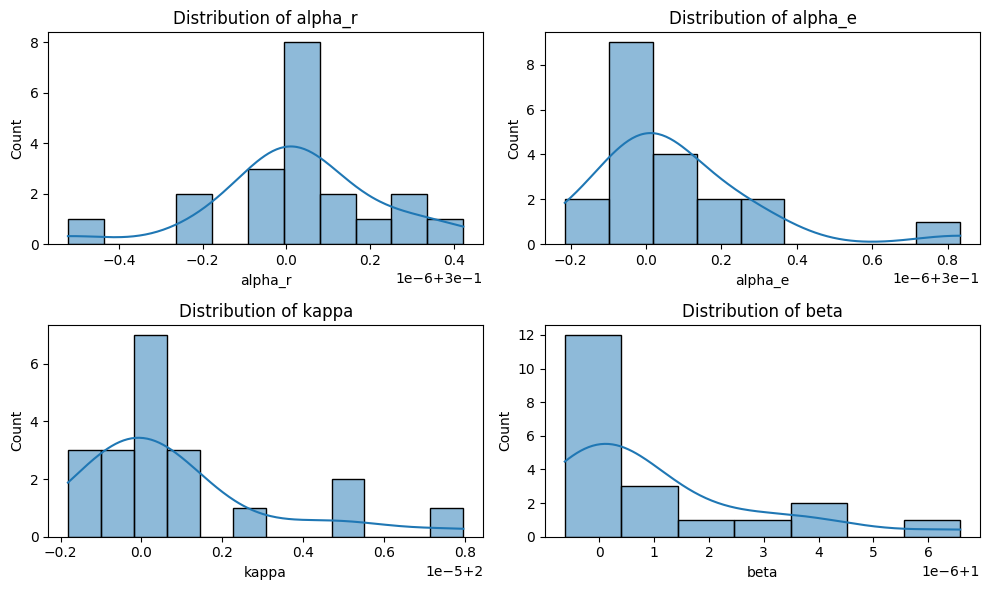

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def main():
    # Suppose 'big_dataframe' is your entire dataset, with columns:
    # ['id','trial','threshold','reward','chosen_effort', ...(maybe 'outcome') ]
    df = big_dataframe.copy()
    unique_ids = df['id'].unique()

    results_list = []

    for pid in unique_ids:
        subdf = df[df['id']==pid].copy()

        # fit with the scaled model
        best_params, best_nll = fit_participant_scaled(
            subdf,
            init_params = [0.3, 0.3, 2.0, 1.0],  # alpha_r, alpha_e, kappa, beta
            bounds      = [(0,1),(0,1),(0,20),(0,10)],
            fixed_sigma = 2.0,                 # scaled domain sigma
            ignore_zero_reward = True
        )
        alpha_r, alpha_e, kappa, beta = best_params

        results_list.append({
            'id': pid,
            'alpha_r': alpha_r,
            'alpha_e': alpha_e,
            'kappa'  : kappa,
            'beta'   : beta,
            'nLL'    : best_nll
        })

    results_df = pd.DataFrame(results_list)
    print(results_df)
    results_df.to_csv("fit_results_scaled.csv", index=False)

    # Quick plots
    plt.figure(figsize=(10,6))
    for i, p in enumerate(['alpha_r','alpha_e','kappa','beta'], start=1):
        plt.subplot(2,2,i)
        sns.histplot(data=results_df, x=p, kde=True)
        plt.title(f"Distribution of {p}")
    plt.tight_layout()
    plt.show()


if __name__=='__main__':
    main()


In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

# -------------
# SCALING CONSTANTS
# -------------
EFFORT_SCALE      = 0.1   # 0..100 => 0..10
REWARD_SCALE      = 10.0  # 1..7   => up to 70
MAX_EFFORT_SCALED = 10    # we enumerate e in [0..10]

def model_nll_scaled(params, subdf, fixed_sigma=2.0, ignore_zero_reward=False):
    """
    model_nll_scaled: negative log-likelihood for scaled model.
    params = [alpha_r, alpha_e, kappa, beta]
       alpha_r, alpha_e in [0..1] typical
       kappa: cost scale in [0..some upper bound], e.g. 5 or 10
       beta:  softmax inverse-temp
    subdf: each row has 'threshold','reward','chosen_effort','trial'
    fixed_sigma: success noise in scaled domain (e.g. 2.0)
    ignore_zero_reward: skip zero-reward trials if True
    """

    alpha_r, alpha_e, kappa, beta = params
    sigma = fixed_sigma

    # Initialize hidden states in scaled domain
    R_hat = 40.0  # e.g. real ~4 => scaled 40
    E_hat = 5.0   # e.g. real ~50 => scaled 5

    # Sort subdf by trial
    subdf = subdf.sort_values('trial', ascending=True)
    nLL = 0.0
    eps = 1e-12

    for _, row in subdf.iterrows():
        threshold_real = row['threshold']
        reward_real    = row['reward']
        chosenEff_real = row['chosen_effort']

        if ignore_zero_reward and reward_real==0:
            # skip these trials entirely
            continue

        # scale threshold, reward
        threshold_s = threshold_real * EFFORT_SCALE
        reward_s    = reward_real    * REWARD_SCALE

        # scale chosen effort
        chosenEff_s_float = chosenEff_real * EFFORT_SCALE
        chosenEff_s       = int(round(chosenEff_s_float))
        if chosenEff_s<0: chosenEff_s=0
        if chosenEff_s>MAX_EFFORT_SCALED: chosenEff_s=MAX_EFFORT_SCALED

        # Enumerate possible scaled efforts
        e_values = np.arange(MAX_EFFORT_SCALED+1)
        EU = np.zeros_like(e_values, dtype=float)

        for iE, eTest in enumerate(e_values):
            p_succ = norm.cdf((eTest - E_hat)/sigma)
            # cost always
            EU[iE] = p_succ*R_hat - kappa*eTest

        # softmax
        EU_max = np.max(EU)
        expEU  = np.exp(beta*(EU - EU_max))
        p_e    = expEU / np.sum(expEU)

        # Probability of observed chosen effort
        p_chosen = max(p_e[chosenEff_s], eps)
        nLL -= np.log(p_chosen)

        # if we have outcome, read it, else simulate
        if 'outcome' in row:
            outcome = row['outcome']
        else:
            p_succ_obs = norm.cdf((chosenEff_s - E_hat)/sigma)
            outcome = 1 if (np.random.rand()<p_succ_obs) else 0

        # received reward in scaled domain
        rec_rwd_s = reward_s if outcome==1 else 0.0

        # update R_hat, E_hat
        delta_r = rec_rwd_s - R_hat
        R_hat  += alpha_r*delta_r

        delta_e = threshold_s - E_hat
        E_hat  += alpha_e*delta_e
        E_hat   = np.clip(E_hat, 0, MAX_EFFORT_SCALED)

    return nLL


In [13]:
def simulate_participant_scaled(subdf,
                                alpha_r, alpha_e, kappa, beta,
                                fixed_sigma=2.0,
                                ignore_zero_reward=False,
                                policy='softmax'):
    """
    Forward-simulate in scaled domain, then convert predicted efforts
    back to real domain.
    """
    df_sorted = subdf.sort_values('trial', ascending=True).reset_index(drop=True).copy()

    # Initialize scaled states
    R_hat = 40.0
    E_hat = 5.0

    preds = []
    outs  = []

    for i, row in df_sorted.iterrows():
        threshold_real = row['threshold']
        reward_real    = row['reward']

        if ignore_zero_reward and reward_real==0:
            preds.append(np.nan)
            outs.append(np.nan)
            continue

        thr_s = threshold_real*EFFORT_SCALE
        rwd_s = reward_real   *REWARD_SCALE

        # enumerations in scaled domain
        e_values = np.arange(MAX_EFFORT_SCALED+1)
        EU = np.zeros_like(e_values)

        for iE,eTest in enumerate(e_values):
            p_succ = norm.cdf((eTest - E_hat)/fixed_sigma)
            # cost always
            EU[iE] = p_succ*R_hat - kappa*eTest

        if policy=='argmax':
            chosen_e_s = e_values[np.argmax(EU)]
        else:
            maxEU = np.max(EU)
            expEU= np.exp(beta*(EU-maxEU))
            p_e  = expEU/np.sum(expEU)
            chosen_e_s = np.random.choice(e_values, p=p_e)

        p_succ_chosen = norm.cdf((chosen_e_s - E_hat)/fixed_sigma)
        outcome = 1 if (np.random.rand()<p_succ_chosen) else 0

        # update
        rec_rwd_s = rwd_s if outcome==1 else 0
        R_hat += alpha_r*(rec_rwd_s - R_hat)
        E_hat += alpha_e*(thr_s - E_hat)
        E_hat  = np.clip(E_hat, 0,MAX_EFFORT_SCALED)

        # convert chosen effort back
        chosen_e_real = chosen_e_s / EFFORT_SCALE
        preds.append(chosen_e_real)
        outs.append(outcome)

    df_sorted['predicted_effort'] = preds
    df_sorted['sim_outcome']      = outs
    return df_sorted




In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_fit(sim_df):
    df_clean = sim_df.dropna(subset=['chosen_effort','predicted_effort'])
    if len(df_clean)==0:
        return {'corr': np.nan, 'rmse': np.nan, 'n':0}

    corr = df_clean['chosen_effort'].corr(df_clean['predicted_effort'])
    errors = df_clean['chosen_effort'] - df_clean['predicted_effort']
    rmse = np.sqrt(np.mean(errors**2))

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df_clean['chosen_effort'], color='blue', alpha=0.5, kde=True, label='Observed')
    sns.histplot(df_clean['predicted_effort'], color='red', alpha=0.5, kde=True, label='Predicted')
    plt.title("Effort Distribution")
    plt.legend()

    plt.subplot(1,2,2)
    sns.scatterplot(x='chosen_effort', y='predicted_effort', data=df_clean, alpha=0.7)
    plt.title(f"corr={corr:.2f}, rmse={rmse:.2f}")
    plt.xlabel("Observed Effort")
    plt.ylabel("Predicted Effort")
    plt.tight_layout()
    plt.show()

    return {'corr':corr, 'rmse':rmse, 'n':len(df_clean)}





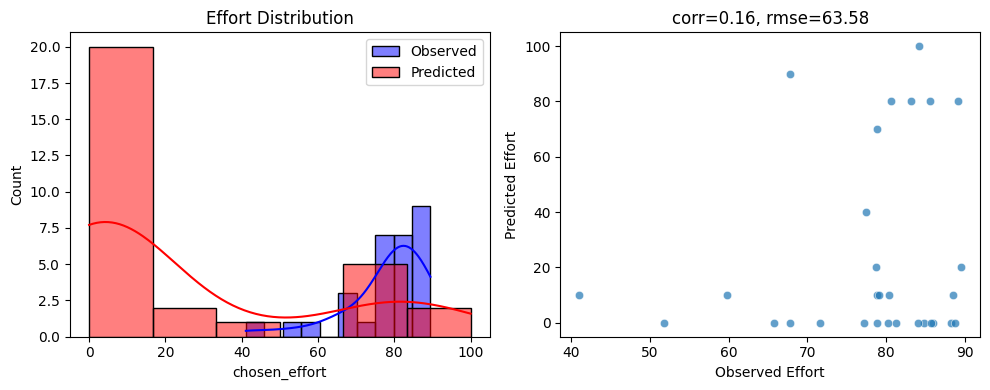

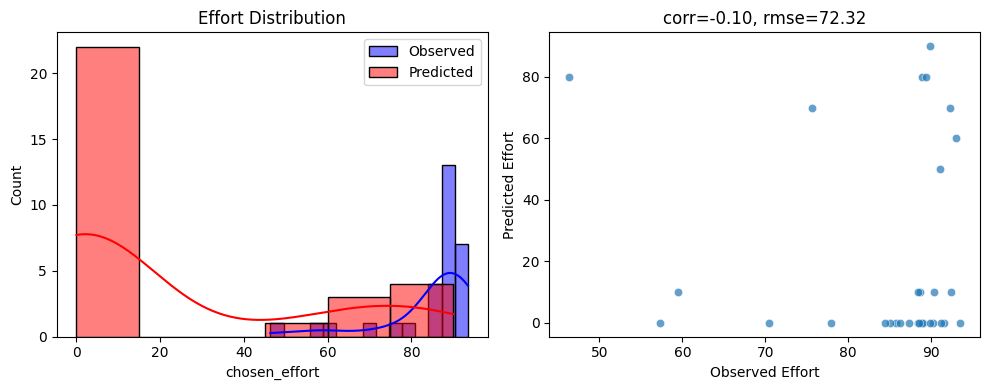

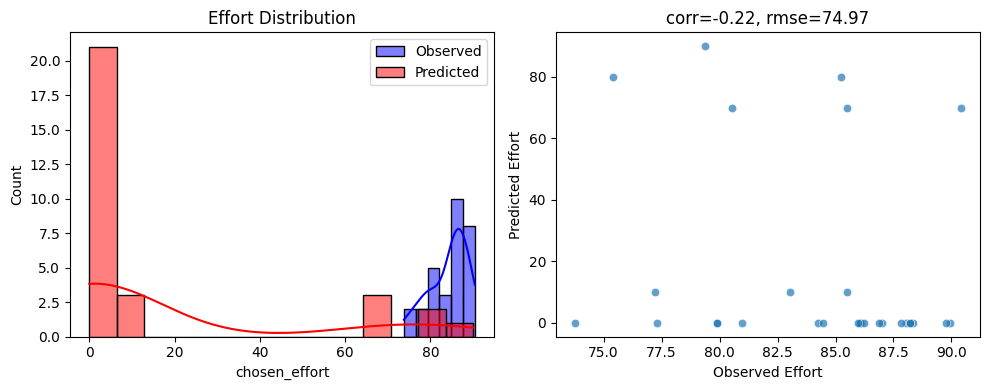

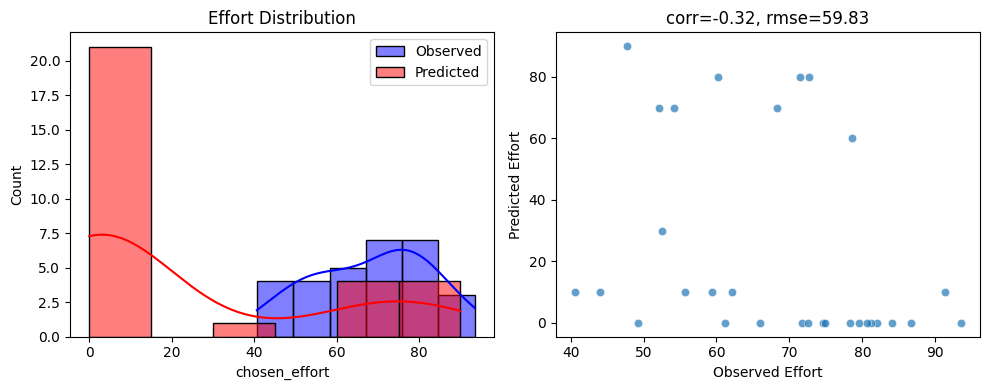

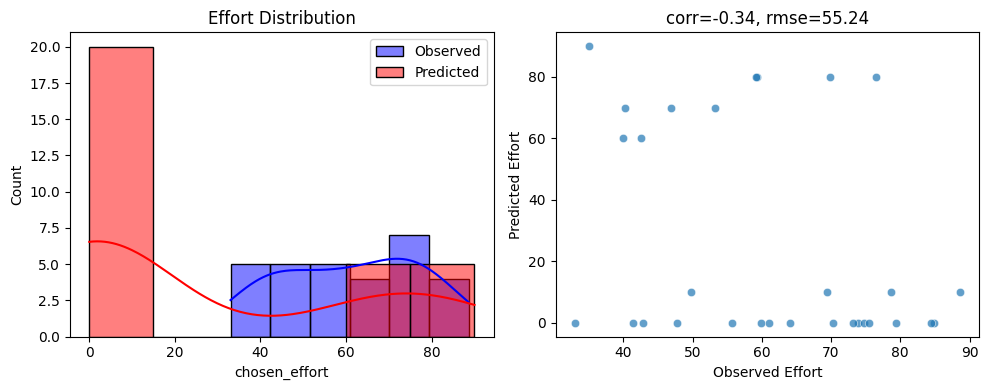

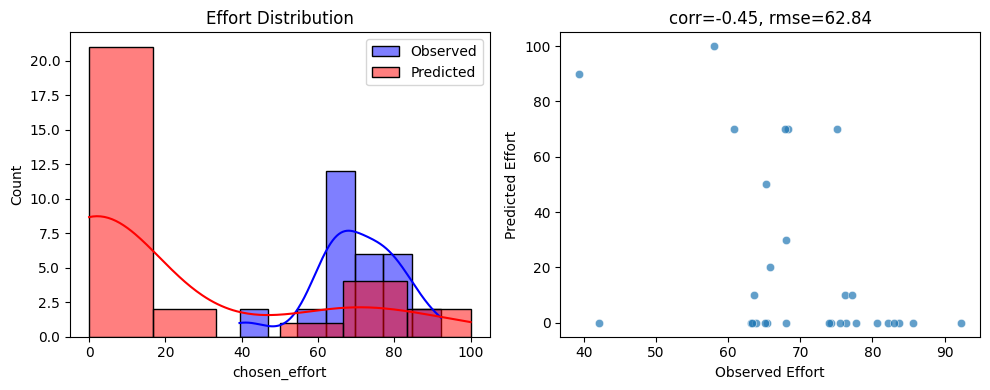

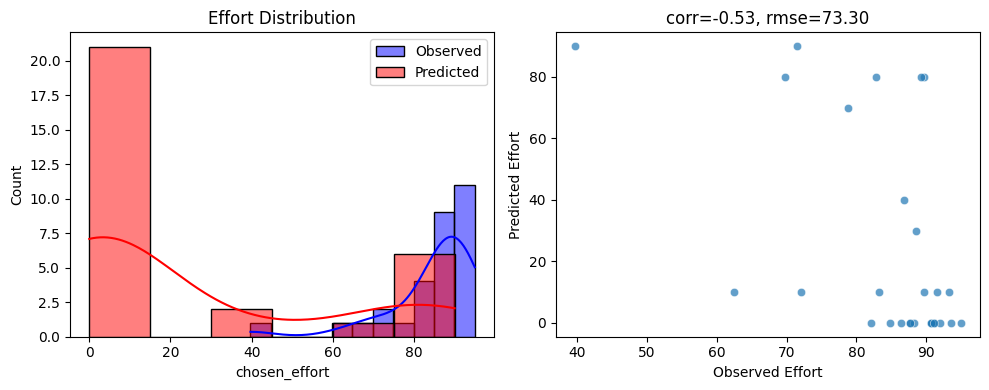

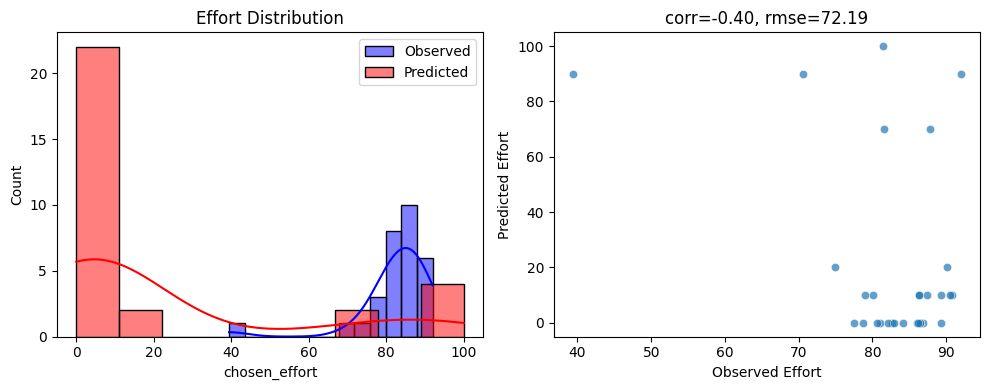

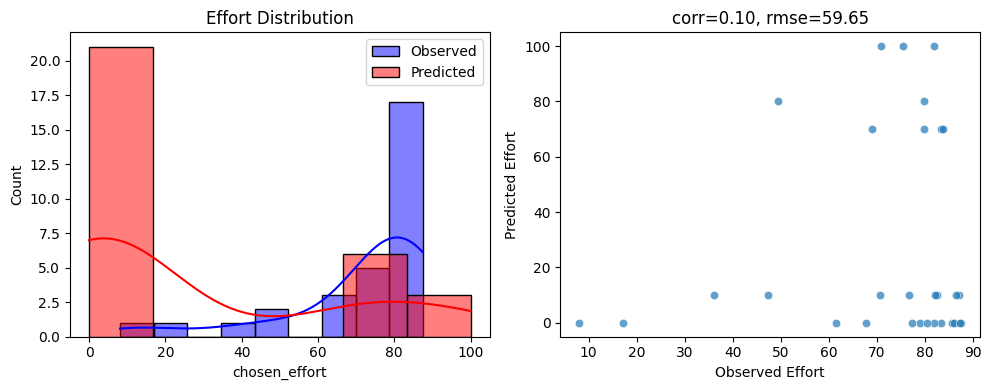

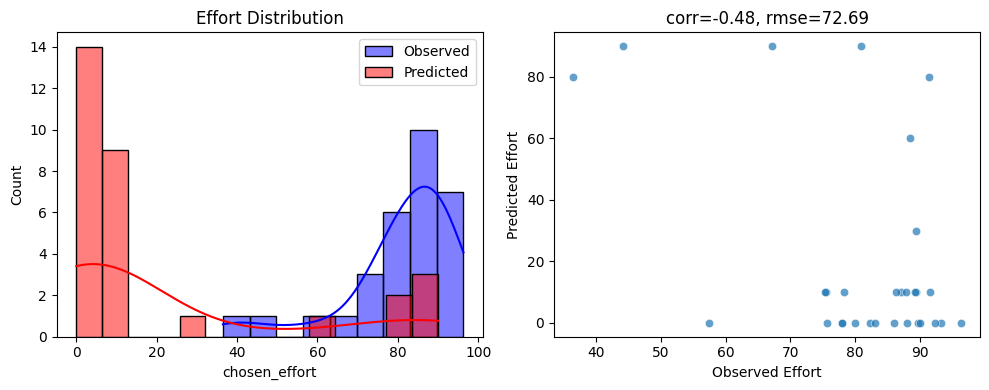

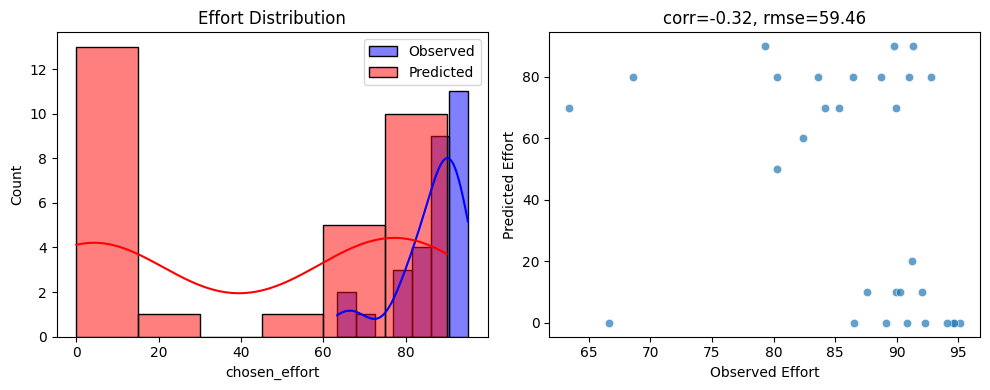

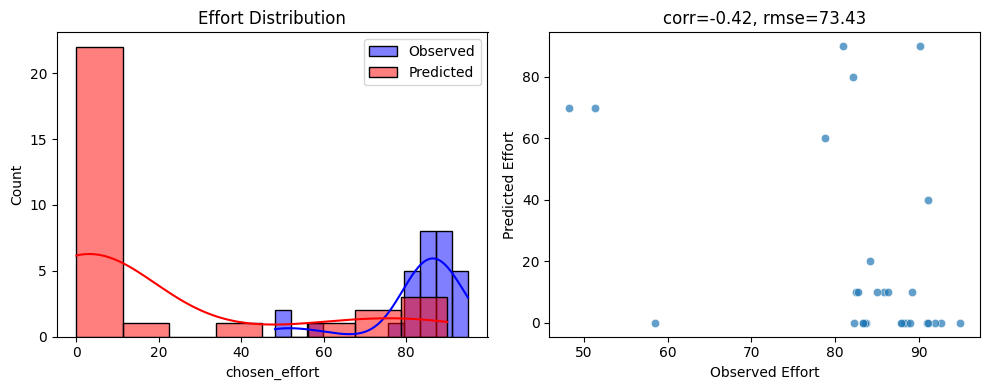

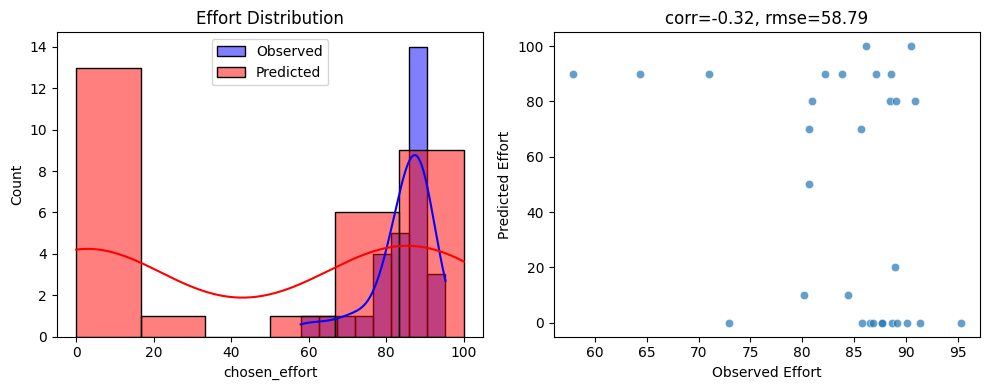

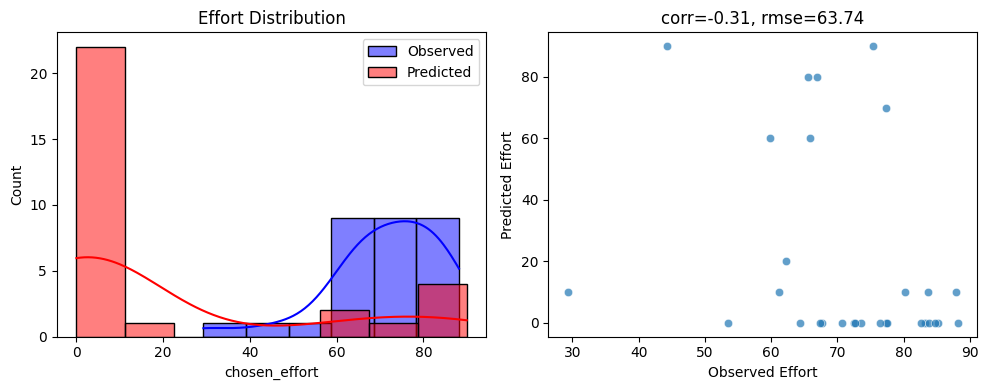

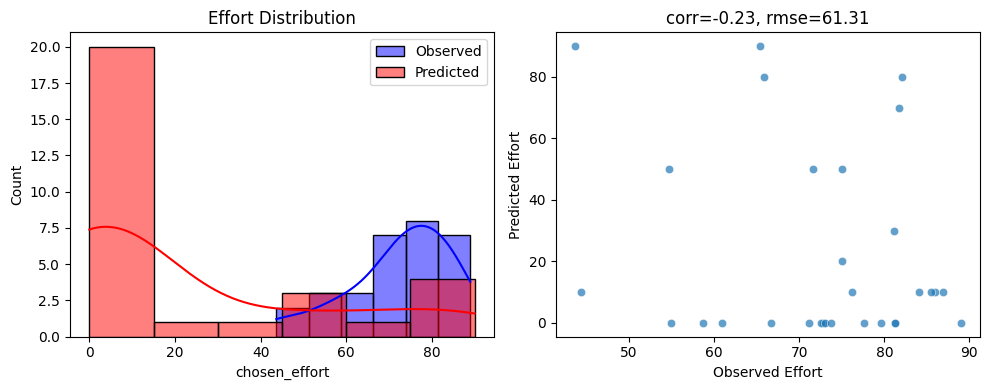

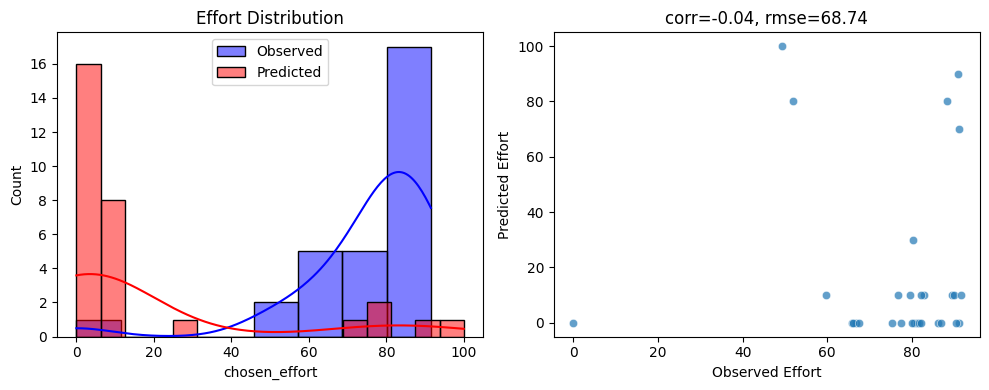

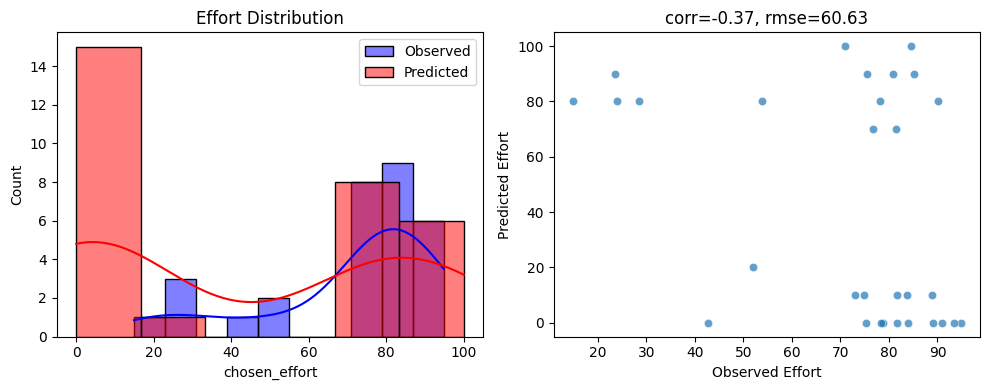

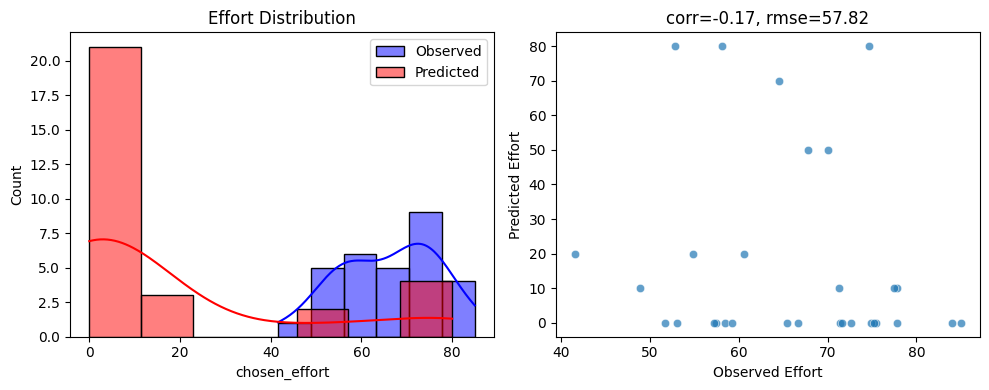

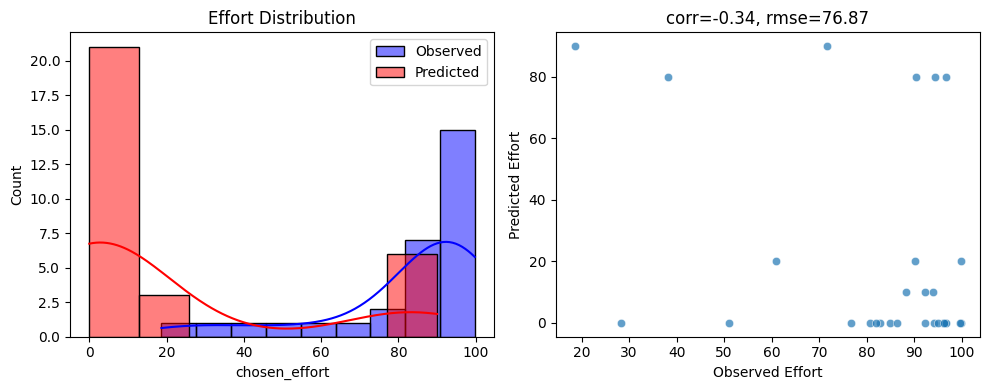

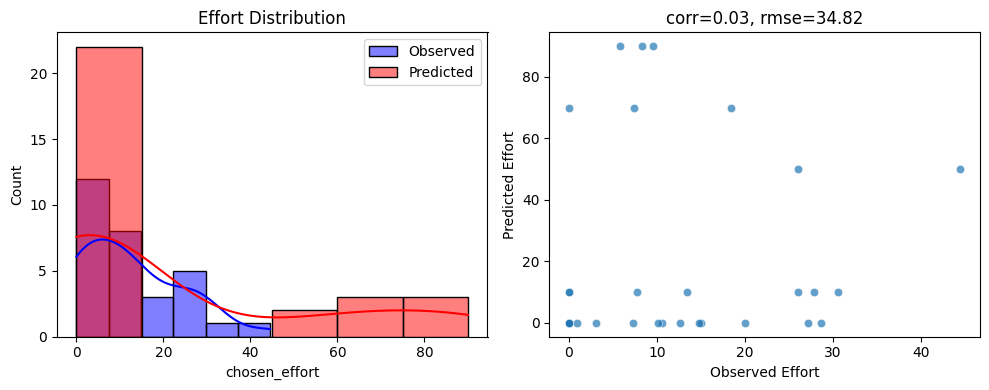

    id   alpha_r   alpha_e     kappa      beta         nLL      corr  \
0    1  0.300000  0.300000  2.000000  1.000000   99.287813  0.160348   
1    3  0.300000  0.300000  2.000000  1.000000   99.809520 -0.095421   
2    4  0.300000  0.300000  2.000000  1.000000   69.581032 -0.218132   
3    7  0.299999  0.299999  2.000007  1.000021  137.180810 -0.322031   
4    8  0.300000  0.300000  2.000000  1.000000  184.756332 -0.339385   
5    9  0.300000  0.300000  2.000000  1.000000  123.270486 -0.452807   
6   10  0.300000  0.300000  2.000000  1.000000   78.672344 -0.527837   
7   11  0.300001  0.300001  1.999998  0.999999   91.040986 -0.395776   
8    5  0.300000  0.300000  2.000000  1.000000  146.933475  0.104301   
9    2  0.300000  0.300000  2.000000  1.000001  130.582689 -0.483941   
10  12  0.300000  0.300001  1.999999  1.000003   59.961455 -0.324108   
11  13  0.300000  0.300000  1.999997  0.999999  101.125728 -0.418471   
12  14  0.300000  0.300000  2.000000  1.000000   65.404473 -0.32

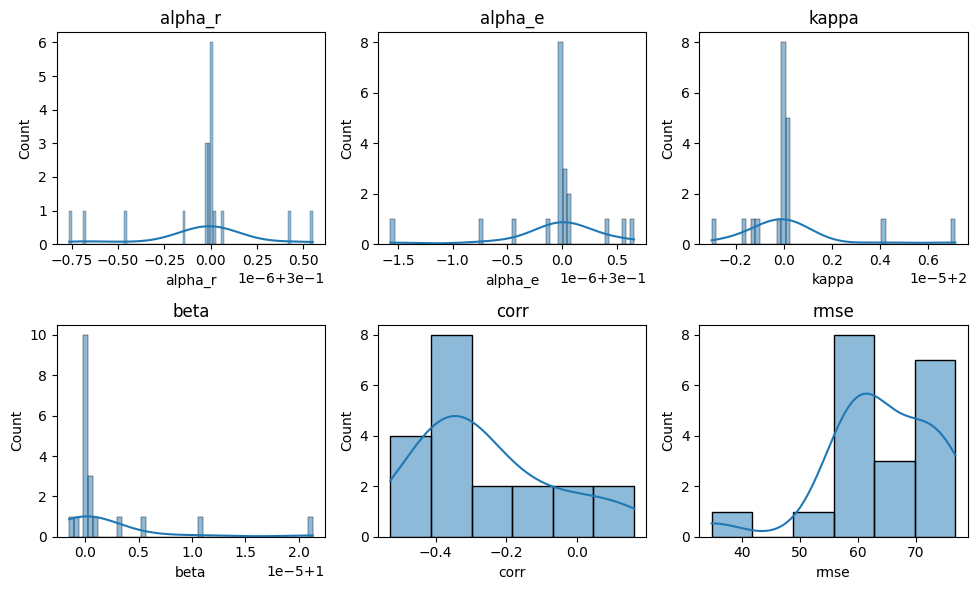

In [15]:
def main():
    # suppose big_dataframe has: ['id','trial','threshold','reward','chosen_effort']
    df = big_dataframe.copy()
    unique_ids = df['id'].unique()

    results_list = []

    for pid in unique_ids:
        subdf = df[df['id']==pid].copy().reset_index(drop=True)

        # Fit
        best_params, best_nll = fit_participant_scaled(
            subdf,
            init_params=[0.3,0.3,2.0,1.0],
            bounds=[(0,1),(0,1),(0,5),(0,10)],
            fixed_sigma=2.0,
            ignore_zero_reward=True
        )
        alpha_r, alpha_e, kappa, beta = best_params

        # Simulate
        sim_df = simulate_participant_scaled(
            subdf,
            alpha_r, alpha_e, kappa, beta,
            fixed_sigma=2.0,
            ignore_zero_reward=True,
            policy='softmax'
        )

        # Evaluate
        fit_stats = evaluate_fit(sim_df)

        results_list.append({
            'id': pid,
            'alpha_r': alpha_r,
            'alpha_e': alpha_e,
            'kappa'  : kappa,
            'beta'   : beta,
            'nLL'    : best_nll,
            'corr'   : fit_stats['corr'],
            'rmse'   : fit_stats['rmse'],
            'n'      : fit_stats['n']
        })

    results_df = pd.DataFrame(results_list)
    print(results_df)
    results_df.to_csv("fit_results_scaled_freeParams.csv", index=False)

    # Quick distribution plot of final params
    plt.figure(figsize=(10,6))
    for i, p in enumerate(['alpha_r','alpha_e','kappa','beta','corr','rmse'], start=1):
        plt.subplot(2,3,i)
        sns.histplot(results_df[p], kde=True)
        plt.title(p)
    plt.tight_layout()
    plt.show()


if __name__=="__main__":
    main()


 
